In [ ]:
!pip --version

pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [ ]:
#prerequisites
!pip install datasets transformers torch
!pip install accelerate -U

In [ ]:
!git clone https://github.com/ashwin63/AI_Human_Image_Classification.git

fatal: destination path 'AI_Human_Image_Classification' already exists and is not an empty directory.


In [ ]:
import numpy as np
from datasets import load_dataset
from transformers import ViTFeatureExtractor
import torch
from transformers import TrainingArguments
from transformers import Trainer
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from transformers import ViTForImageClassification, default_data_collator
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

In [ ]:
print(torch.__version__)
import transformers, tensorflow, numpy
print(transformers.__version__)
print(tensorflow.__version__)
print(numpy.__version__)

2.2.1+cu121
4.40.0
2.15.0
1.25.2


## Data Augmentation

## Printing Augmented Imgages

In [ ]:
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torch.utils.data import DataLoader

# Define the data augmentation pipeline
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Mirrors the image horizontally
    transforms.RandomRotation(20),  # Maximum rotation angle
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

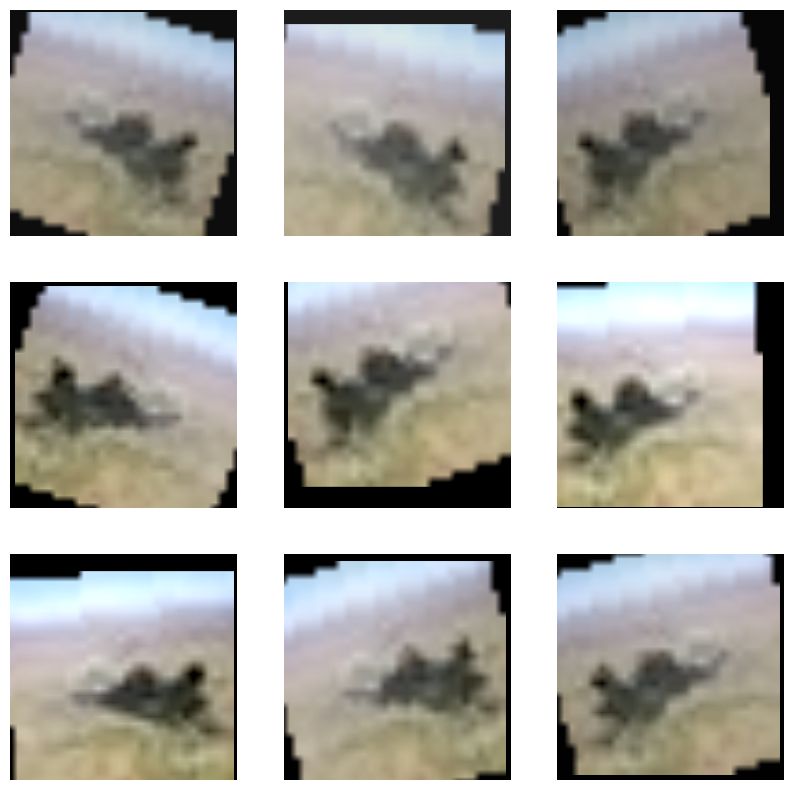

In [ ]:
def show_augmented_images(dataset, index, augment_transforms, num_images=9):
    image = Image.open(dataset.img_files[index]).convert('RGB')  # Load and convert the image

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        # Apply the augmentation transform
        augmented_image = augment_transforms(image)
        plt.imshow(augmented_image)
        plt.axis('off')
    plt.show()

# Assuming `train_dataset` is your dataset instance already loaded with paths
show_augmented_images(train_dataset, 0, data_augmentation)


In [ ]:
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)
# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=2
)
model.to(device)

# Initialize the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# Create the dataset
train_dataset = CustomImageDataset(img_dir='/content/AI_Human_Image_Classification/dataset/train', feature_extractor=feature_extractor)
test_dataset = CustomImageDataset(img_dir='/content/AI_Human_Image_Classification/dataset/test', feature_extractor=feature_extractor)

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/preprocessor_config.json
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "d

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, feature_extractor):
        self.img_dir = img_dir
        self.img_labels = []
        self.img_files = []
        self.feature_extractor = feature_extractor
        self.label_mapping = {'REAL': 1, 'FAKE': 0}

        for label_dir in ['REAL', 'FAKE']:
            dir_path = os.path.join(img_dir, label_dir)
            files = os.listdir(dir_path)
            for file in files:
                self.img_files.append(os.path.join(dir_path, file))
                self.img_labels.append(self.label_mapping[label_dir])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels[idx]
        features = self.feature_extractor(images=image, return_tensors="pt")
        # Ensure the output is in a dictionary format
        return {"pixel_values": features['pixel_values'].squeeze(), "labels": torch.tensor(label)}

# class CustomImageDataset(Dataset):
#     def __init__(self, img_dir, feature_extractor, augment=False):
#         self.img_dir = img_dir
#         self.img_labels = []
#         self.img_files = []
#         self.feature_extractor = feature_extractor
#         self.augment = augment
#         self.label_mapping = {'REAL': 1, 'FAKE': 0}

#         for label_dir in ['REAL', 'FAKE']:
#             dir_path = os.path.join(img_dir, label_dir)
#             files = os.listdir(dir_path)
#             for file in files:
#                 self.img_files.append(os.path.join(dir_path, file))
#                 self.img_labels.append(self.label_mapping[label_dir])

#         # Data augmentation transform
#         self.data_augmentation = transforms.Compose([
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(36),
#             transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
#             transforms.RandomAdjustSharpness(sharpness_factor=2),
#             transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#             transforms.ColorJitter(brightness=0.2, contrast=0.2),
#         ])

#     def __len__(self):
#         return len(self.img_files)

#     def __getitem__(self, idx):
#         img_path = self.img_files[idx]
#         image = Image.open(img_path).convert("RGB")
#         if self.augment:
#             image = self.data_augmentation(image)
#         features = self.feature_extractor(images=image, return_tensors="pt")
#         return {"pixel_values": features['pixel_values'].squeeze(), "labels": torch.tensor(self.img_labels[idx])}





In [ ]:
from transformers import TrainerCallback

class LossHistory(TrainerCallback):
    "A callback that records eval loss into a list."
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # We extract the loss from the logs and record it
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

In [ ]:
# Setup logging
import logging
from transformers import set_seed, logging

logging.set_verbosity_info()
set_seed(42)

training_args = TrainingArguments(
    output_dir="./cifar",
    per_device_train_batch_size=4,
    evaluation_strategy="steps",
    num_train_epochs=4,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
)

loss_history = LossHistory()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
    compute_metrics=None,  # Define your metrics function if needed
    callbacks=[loss_history]
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 100,000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 85,800,194


Step,Training Loss,Validation Loss
100,0.361300,0.348319


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8
Saving model checkpoint to ./cifar/checkpoint-100
Configuration saved in ./cifar/checkpoint-100/config.json
Model weights saved in ./cifar/checkpoint-100/model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./cifar/checkpoint-100 (score: 0.3483193516731262).


TrainOutput(global_step=100, training_loss=0.5573485708236694, metrics={'train_runtime': 269.5752, 'train_samples_per_second': 1.484, 'train_steps_per_second': 0.371, 'total_flos': 3.09967958458368e+16, 'train_loss': 0.5573485708236694, 'epoch': 0.004})

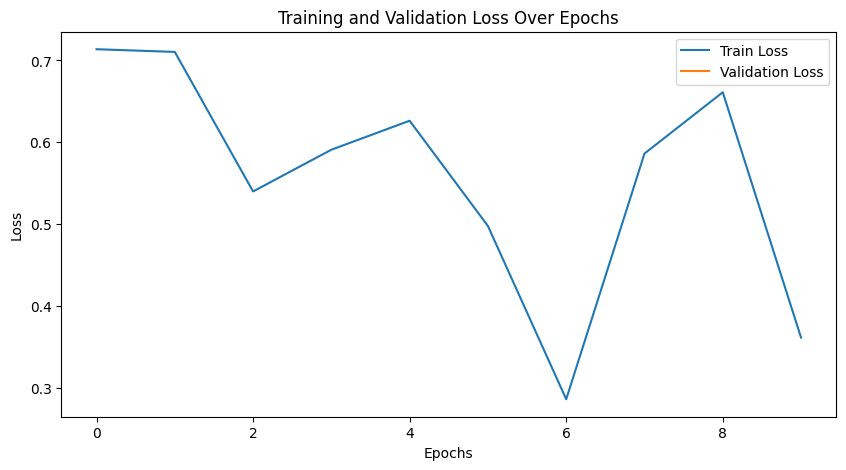

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history.train_losses, label='Train Loss')
plt.plot(loss_history.eval_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_path = "/content"
model.save_pretrained(model_path)
feature_extractor.save_pretrained(model_path)

Configuration saved in /content/config.json
Model weights saved in /content/model.safetensors
Image processor saved in /content/preprocessor_config.json


['/content/preprocessor_config.json']

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['labels'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions, true_labels = get_predictions(model, test_loader, device)

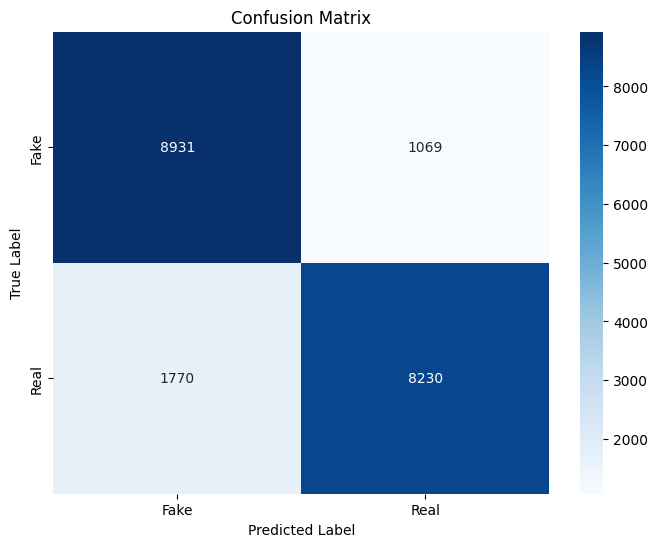

F1 Score: 0.85
Precision: 0.89
Recall: 0.82
Sensitivity: 0.82
Specificity: 0.89


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
precision, recall, f_score, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display precision, recall, sensitivity, and specificity
print(f"F1 Score: {f_score:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

## Prediction
Load Model and Feature Extractor

In [ ]:
# Path to your trained model
# model_path = "/content"

# Load the feature extractor and model
feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)
model = ViTForImageClassification.from_pretrained(model_path)

# Assuming you're using a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loading configuration file /content/preprocessor_config.json
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Image processor ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

loading configuration file /content/config.json
Model config ViT

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

## Load and Preprocess the Image

In [ ]:
# Replace 'path_to_your_image.jpg' with the path to the image you want to predict
image_path = '/content/image5_1.jpeg'
image = Image.open(image_path).convert("RGB")

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")

# Move preprocessed inputs to the correct device
pixel_values = inputs['pixel_values'].to(device)

## Make a Prediction
Now, you can use your model to make a prediction:

Predicted Label: FAKE


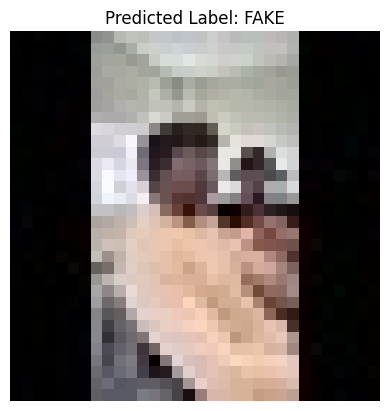

In [ ]:
# Set model to evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    outputs = model(pixel_values)

# Extract predicted class probabilities
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# Translate the model's numerical output to a human-readable label
predicted_label = 'REAL' if predicted_class_idx == 1 else 'FAKE'

print(f"Predicted Label: {predicted_label}")

plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title(f"Predicted Label: {predicted_label}")
plt.show()